# Tutorial: tune cells from AllenDB

In [1]:
# If running in Colab
!pip install --quiet --upgrade pip
!pip install --quiet allensdk neuron
!git clone -b release_candidate https://github.com/V-Marco/ACT.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.1/973.1 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 143.2 MB/s eta 0:00:00
   

In [1]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

## Step 1: Download the cell

Use [this notebook](https://github.com/cyneuro/single-cell-tuning/blob/main/download_build_from_allendb.ipynb) to download the cell from AllenDB.

## Step 2 (optional): Segregate the cell's modfiles

Separate the cell's channels into distinct modules by cutting their activation curves at some voltage threshold. Some principles that work empirically:

1. Cut the activation curve of the h channel 2-3 mV to the left of V-rest.
2. Cut activation curves of active channels at least 2-3 mV to the right of V-rest to prevent spurious spikes in the beginning of the simulation.

[This notebook](https://colab.research.google.com/github/V-Marco/ACT/blob/release_candidate/segregation.ipynb) provides examples of segregation.

## Step 3: Upload your cell files to the working directory

For example,

In [7]:
!git clone https://github.com/cyneuro/single-cell-tuning.git
!cp -r /content/single-cell-tuning/Segregated/ ./
%cd Segregated/

fatal: destination path 'single-cell-tuning' already exists and is not an empty directory.


## Step 4: Build the cell and get soma morphology parameters

In [37]:
# Compile the modfiles
!nrnivmodl modfiles > /dev/null 2>&1

In [13]:
def build_cell(soma_diam_multiplier = 1):
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h

    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)

    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()

    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

def set_simulation(stim_amp, soma_diam_multiplier = 1.0):
    h = build_cell(soma_diam_multiplier)

    stim = h.IClamp(h.soma[0](0.5))
    stim.amp = stim_amp
    stim.delay = 300.0
    stim.dur = 1000
    h.tstop = 1500.0
    h.dt = 0.1
    h.steps_per_ms = 1 / h.dt

    return h, stim

In [5]:
h = build_cell()

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


In [6]:
print(f"Soma area: {h.soma[0](0.5).area()}")
print(f"Soma diam: {h.soma[0].diam}")
print(f"Soma L: {h.soma[0].L}")

Soma area: 503.6323076932052
Soma diam: 12.661399841308594
Soma L: 12.661407470703125


## Step 5: Tune passive properties (PP)

1. Define the original soma area and desired PP.

In [7]:
# Soma area from the previous cell
computed_soma_area = 5.036323076932052e-06 # (cm2)

# User-provided desired properties
user_provided_Rin = 195.4 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 15.6 * 1e-3 # (to s from ms)
user_provided_Vrest = -71 # (mV)

2. We cannot set R-in, tau and V-rest for the cell directly – instead, we have to compute g-bar-leak, Cm and e-rev-leak, set these, and then see if the cell outputs desired R-in, tau, V-rest.

`ACTPassiveModule` computes g-bar-leak, Cm and e-rev-leak (called `SettablePassiveProperties`) from R-in, tau and V-rest (called `GettablePassiveProperties`) using analytical formulas.

**NOTE:** properties are only **computed** and not set. To set Cm, etc. you have to **manually edit the "_fit.json" file**.

In [9]:
# Compute the settable properties
ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)

SettablePassiveProperties(Cm=1.5852087355778763, g_bar_leak=0.00010161594458832541, e_rev_leak=-71, g_bar_h=None)

3. Open the "_fit.json" file and:

    3.1. Set all active conductances to 0 (i.e., all g-s but g-leak and g-h).

    3.2 Set "e_pas" to `e_rev_leak`.

    3.3. Set "cm" of all sections to `Cm`.

    3.4 Set "g_pas" of all sections to `g_bar_leak`.

4. Apply a small negative current injection (e.g., -0.1 nA) to get the passive voltage trace.

**NOTE:** do not make the amplitude too high, it leads to spurious results.

In [ ]:
h, stim = set_simulation(-0.1)
v = h.Vector().record(h.soma[0](0.5)._ref_v)
h.finitialize()
h.run()
plt.plot(v.as_numpy()[::10])

5. Compute R-in, tau and V-rest using `ACTPassiveModule`.

In [ ]:
print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, 300, 1290, -0.1))
print(f"V-rest: {v.as_numpy()[300]}")

6. Repeat steps 3-5 until you get close to the desired PP. Some principles:

    - Decrease soma area to increase R-in.

    - Increase Cm to increase tau.

    - Increase g-bar-leak to decrease R-in and tau.

For the SST example, we made the following adjustments:
1. cm = 3
2. g-pas = 0.00015242391688248812
3. e-pas = -67
4. soma_diam = soma diam * 0.6

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768


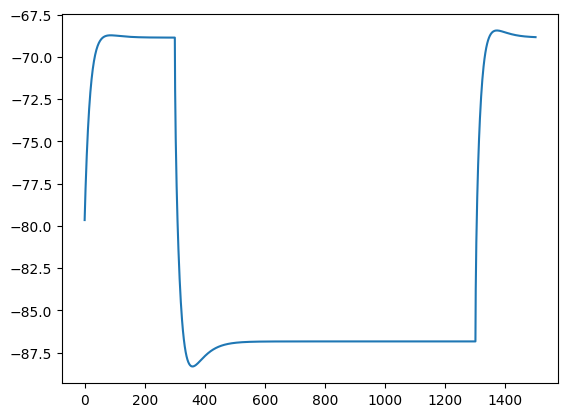

In [14]:
h, stim = set_simulation(stim_amp = -0.1, soma_diam_multiplier = 0.6)
v = h.Vector().record(h.soma[0](0.5)._ref_v)
h.finitialize()
h.run()
plt.plot(v.as_numpy()[::10])

In [15]:
print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, 300, 1290, -0.1))
print(f"V-rest: {v.as_numpy()[300]}")

GettablePassiveProperties(R_in=194.7525139028619, tau1=11.700000000000001, tau2=63.0, sag_ratio=0.07619332016214711)
V-rest: -70.35248813302549


## Step 6: Tune the FI curve

Finally, tune the FI curve. Some guidelines:

1. First, turn on persistent sodium (e.g., Nap), transient sodium (e.g., NaT) and persistent potassium (e.g., Kdr) channels. Suggested conductances to start with:
    - g-NaP = 0.0011
    - g-NaT = 0.08
    - g-Kdr = 0.026

Get the FI curve to the desired range of values. It is fine if at this stage the rheobase and the slope do not match perfectly, but the F values themselves should be in the range of the desired values.

2. Next, turn on calcium channels (e.g., CaLVA, CaHVA) and calcium-activated potassium channels (e.g., SK). Suggested parameters to start with:
    - g-CaLVA = 0.0005
    - g-CaHVA = 0.0007
    - decayCa = 85
    - gammaCa = 0.003
    - g-SK = 9.5e-2

Refine the rheobase and the slope of the FI curve. Some principles:
- Changing Ca-HVA + SK affects the F values at higher I values, thus changing the slope.
- Increasing NaP generally decreases the rheobase.

3. When tuning is done, make sure PP properties are unchanged.

In [16]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [ ]:
frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

for amp in amps:
    h, stim = set_simulation(amp)
    v = h.Vector().record(h.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(count_voltage_events(np.arange(len(v.as_numpy()))[2990:13010], v.as_numpy()[2990:13010]))

warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root at line 15883
  root at line 16161
  root at line 16200
  root at line 16210
  root at line 16253
  root at line 16286
  root at line 16301
  root at line 16326
  root at line 16574
  root at line 16613
  root at line 16618
  root at line 16645
  root at line 16695
  root at line 16751
  root at line 16765
  root at line 16768
warning ./Sst-IRES-Cre_Ai14-188740.03.02.01_657210399_m.swc: more than one tree:
  root at line 4
  root at line 14504
  root at line 14725
  root at line 14798
  root at line 15141
  root at line 15144
  root at line 15156
  root at line 15211
  root at line 15318
  root at line 15496
  root at line 15811
  root at line 15857
  root

In [ ]:
for a, f in zip(amps, frequenies):
    print(f"{a}: {f}")

-0.1: 0
-0.05: 0
0: 0
0.05: 8
0.1: 29
0.15: 47
0.2: 59
0.25: 71
0.3: 73


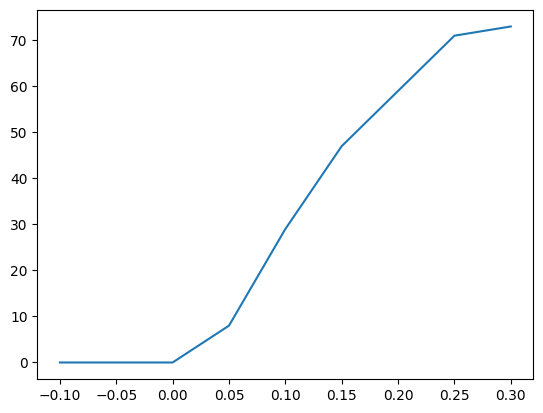

In [ ]:
# Change NaP to shift rheobase
# Change SK to change slope
plt.plot(amps, frequenies)

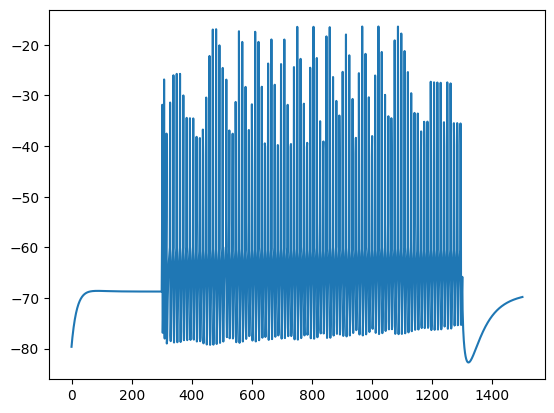

In [ ]:
plt.plot(v.as_numpy()[::10])